## Car Damage Severity Classification
### Autumn Mizer, Peter Kwaterski,

This notebook implements a deep learning model using InceptionV3 which is pretrained on ImageNet to classify car damage severity into minor, moderate, and severe. The dataset is made by Prajwal Bhamere and comes from https://www.kaggle.com/datasets/prajwalbhamere/car-damage-severity-dataset/data.

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, AdamW
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

2025-11-16 17:46:09.502773: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-16 17:46:09.503145: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-16 17:46:09.576717: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 17:46:14.856738: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

The code segment below takes care of data processing and augmentation. The InceptionV3 model is trained for 299x299 RGB images, so the datasets images need to be scaled to work as intended with the base model. These augmentation settings were also found to be helpful for training accuracy for this dataset, and is also done to prevent overfitting. Only rescaling has been done to the validation data.

In [ ]:
img_size = (299,299) # inceptionv3 requires 299x299 rgb
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.7, 1.3],
    horizontal_flip=True,
    fill_mode='nearest'
)

train = datagen.flow_from_directory(
    "dataset/train",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

datagen = ImageDataGenerator(rescale=1./255)

val = datagen.flow_from_directory(
    "dataset/val",
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 1383 images belonging to 3 classes.


Found 248 images belonging to 3 classes.


The code segment below contains the base model implementation of InceptionV3. It uses the pretrained ImageNet weights.

More information can be found here for the base model
https://keras.io/api/applications/inceptionv3/

In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

#freeze layers in base model
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
#classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(.3)(x)
preds = Dense(3, activation='softmax')(x)

#model to new head
model = Model(inputs=base_model.input, outputs=preds)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=5e-4), #head training
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history_head = model.fit(
    train,
    validation_data = val,
    epochs=10
)

/opt/miniconda3/envs/py312/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 46s 954ms/step - accuracy: 0.4497 - loss: 1.1083 - val_accuracy: 0.6935 - val_loss: 0.8098
Epoch 2/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 926ms/step - accuracy: 0.5799 - loss: 0.9089 - val_accuracy: 0.6250 - val_loss: 0.7677
Epoch 3/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 932ms/step - accuracy: 0.5683 - loss: 0.8887 - val_accuracy: 0.6573 - val_loss: 0.7587
Epoch 4/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 930ms/step - accuracy: 0.6009 - loss: 0.8439 - val_accuracy: 0.7016 - val_loss: 0.7116
Epoch 5/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 927ms/step - accuracy: 0.6052 - loss: 0.8292 - val_accuracy: 0.7379 - val_loss: 0.7016
Epoch 6/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 925ms/step - accuracy: 0.5835 - loss: 0.8484 - val_accuracy: 0.7056 - val_loss: 0.7029
Epoch 7/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 927ms/step - accuracy: 0.6356 - loss: 0.8145 - val_accuracy: 0.7339 - val_loss: 0.6723
Epoch 8/10
44/44 ━━━━━━━━━━━━━━━━━━━━ 41s 931ms/step - accuracy: 0.6074 - loss: 0.8102 - val_accu

Text(0.5, 1.0, 'Loss')

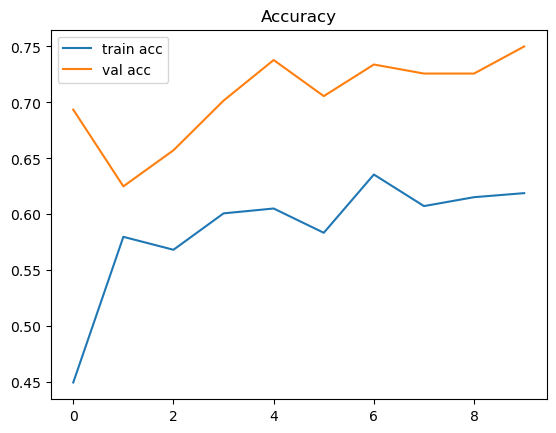

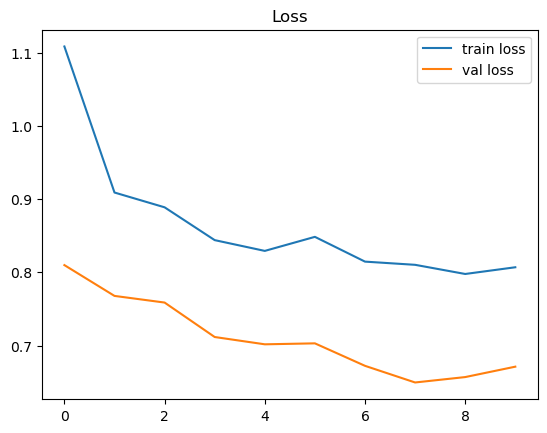

In [ ]:
plt.plot(history_head.history['accuracy'], label='train acc')
plt.plot(history_head.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')

plt.figure()
plt.plot(history_head.history['loss'], label='train loss')
plt.plot(history_head.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')

In [ ]:
num_unfreeze = 100

#unfreeze layers for finetuning
for layer in base_model.layers[-num_unfreeze:]:
    layer.trainable = True

model.compile(
    optimizer=AdamW(learning_rate=1e-5, weight_decay=1e-7), #finetuning pretrained layers
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_tune = model.fit(
    train,
    validation_data=val,
    epochs=30,
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=6,
        restore_best_weights=True
    ) #prevent overfitting
    ]
)  

Epoch 1/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.5589 - loss: 0.8939 - val_accuracy: 0.7339 - val_loss: 0.6269 - learning_rate: 1.0000e-05
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6255 - loss: 0.8029 - val_accuracy: 0.7379 - val_loss: 0.6154 - learning_rate: 1.0000e-05
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6544 - loss: 0.7472 - val_accuracy: 0.7540 - val_loss: 0.6013 - learning_rate: 1.0000e-05
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.6688 - loss: 0.7275 - val_accuracy: 0.7298 - val_loss: 0.5963 - learning_rate: 1.0000e-05
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6811 - loss: 0.6880 - val_accuracy: 0.7540 - val_loss: 0.5800 - learning_rate: 1.0000e-05
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 58s 1s/step - accuracy: 0.6941 - loss: 0.6761 - val_accuracy: 0.7621 - val_loss: 0.5661 - learning_rate: 1.0000e-05
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7158 - loss:

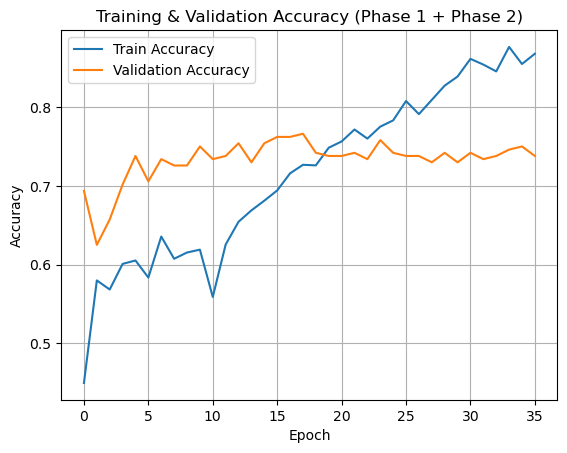

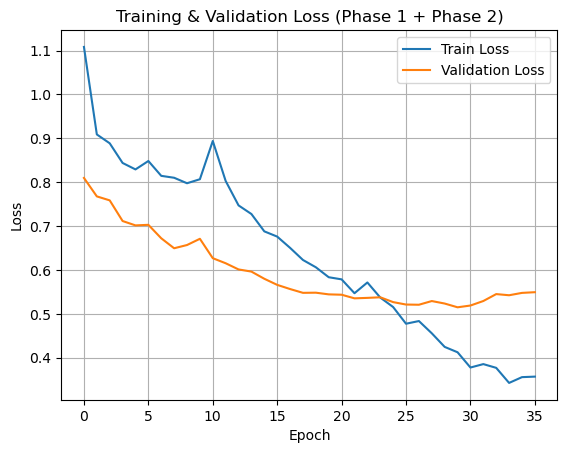

In [ ]:
acc = history_head.history['accuracy'] + history_tune.history['accuracy']
val_acc = history_head.history['val_accuracy'] + history_tune.history['val_accuracy']

loss = history_head.history['loss'] + history_tune.history['loss']
val_loss = history_head.history['val_loss'] + history_tune.history['val_loss'] 

plt.plot(acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training & Validation Accuracy (Phase 1 + Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.plot(loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training & Validation Loss (Phase 1 + Phase 2)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 843ms/step


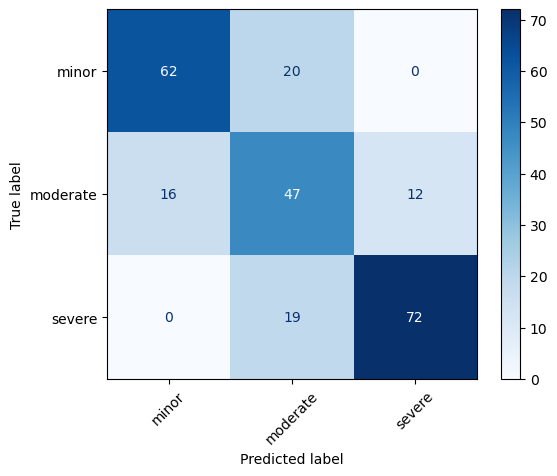

              precision    recall  f1-score   support

       minor       0.79      0.76      0.78        82
    moderate       0.55      0.63      0.58        75
      severe       0.86      0.79      0.82        91

    accuracy                           0.73       248
   macro avg       0.73      0.72      0.73       248
weighted avg       0.74      0.73      0.73       248



In [ ]:
y_true = val.classes
y_pred = model.predict(val)
y_pred_labels = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_labels)
labels = list(train.class_indices.keys())

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.show()

print(classification_report(y_true, y_pred_labels, target_names=labels))